In [1]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import nltk
from nltk.corpus import wordnet
import random

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    if word in synonyms:
        synonyms.remove(word)  # Remove the original word from synonyms
    return list(synonyms)

def synonym_replacement(sentence, n):
    words = nltk.word_tokenize(sentence)
    replaced_sentence = words[:]
    words_indexes = list(range(len(words)))
    random.shuffle(words_indexes)
    
    replaced = 0
    for i in words_indexes:
        synonyms = get_synonyms(words[i])
        if synonyms:
            synonym = random.choice(synonyms)
            replaced_sentence[i] = synonym
            replaced += 1
            if replaced >= n:  # Replace up to n words
                break

    return ' '.join(replaced_sentence)

# Example usage
sentence = "The quick brown fox jumps over the lazy dog"
replaced_sentence = synonym_replacement(sentence, 3)  # Replace up to 3 words
print("Original sentence:", sentence)
print("Sentence after synonym replacement:", replaced_sentence)

[nltk_data] Downloading package wordnet to /home/raaif/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/raaif/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/raaif/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Original sentence: The quick brown fox jumps over the lazy dog
Sentence after synonym replacement: The quick brown bedevil jumps ended the lazy weenie


In [3]:
from transformers import MarianMTModel, MarianTokenizer

def back_translate(text, model_name_src_to_tgt, model_name_tgt_to_src):
    # Initialize the tokenizer and model for source to target language
    tokenizer_src_to_tgt = MarianTokenizer.from_pretrained(model_name_src_to_tgt)
    model_src_to_tgt = MarianMTModel.from_pretrained(model_name_src_to_tgt)
    
    # Translate from source to target language
    translated = model_src_to_tgt.generate(**tokenizer_src_to_tgt(text, return_tensors="pt", padding=True))
    
    # Decode the translated text
    tgt_text = tokenizer_src_to_tgt.decode(translated[0], skip_special_tokens=True)
    
    # Initialize the tokenizer and model for target to source language
    tokenizer_tgt_to_src = MarianTokenizer.from_pretrained(model_name_tgt_to_src)
    model_tgt_to_src = MarianMTModel.from_pretrained(model_name_tgt_to_src)
    
    # Translate back from target to source language
    back_translated = model_tgt_to_src.generate(**tokenizer_tgt_to_src(tgt_text, return_tensors="pt", padding=True))
    
    # Decode the back-translated text
    src_text = tokenizer_tgt_to_src.decode(back_translated[0], skip_special_tokens=True)
    
    return src_text

# Example usage
text = "The quick brown fox jumps over the lazy dog"
text2 = "A hungry man wants to eat a pizza from the local takeaway"
model_name_src_to_tgt = "Helsinki-NLP/opus-mt-en-fr"
model_name_tgt_to_src = "Helsinki-NLP/opus-mt-fr-en"

back_translated_text = back_translate(text2, model_name_src_to_tgt, model_name_tgt_to_src)
print("Original text:", text2)
print("Back-translated text:", back_translated_text)

/home/raaif/.local/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/home/raaif/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/home/raaif/.local/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Original text: A hungry man wants to eat a pizza from the local takeaway
Back-translated text: A hungry man wants to eat a pizza from the corner to take away


In [4]:
import random
import string

def inject_noise(sentence, noise_type='all', noise_level=0.1):
    """
    Injects noise into a given sentence. The type of noise can be specified.
    - sentence: The input sentence to which noise will be added.
    - noise_type: The type of noise to add ('insert', 'delete', 'substitute', or 'all').
    - noise_level: Fraction of characters to alter (between 0 and 1).
    """
    # Function to insert noise: Randomly adds a character within a word
    def insert_noise(word):
        if len(word) > 1:  # Avoid inserting into very short words
            insert_pos = random.randint(1, len(word)-1)  # Avoid inserting at the first position
            insert_char = random.choice(string.ascii_lowercase)
            return word[:insert_pos] + insert_char + word[insert_pos:]
        return word

    # Function to delete noise: Randomly removes a character from a word
    def delete_noise(word):
        if len(word) > 1:
            delete_pos = random.randint(0, len(word)-1)
            return word[:delete_pos] + word[delete_pos+1:]
        return word

    # Function to substitute noise: Replaces a character with a random character
    def substitute_noise(word):
        if len(word) > 1:
            substitute_pos = random.randint(0, len(word)-1)
            substitute_char = random.choice(string.ascii_lowercase)
            return word[:substitute_pos] + substitute_char + word[substitute_pos+1:]
        return word

    noise_functions = {
        'insert': insert_noise,
        'delete': delete_noise,
        'substitute': substitute_noise
    }

    words = sentence.split()
    num_words_to_change = max(1, int(len(words) * noise_level))  # Ensure at least one word is changed
    words_to_change = random.sample(words, num_words_to_change)

    for i, word in enumerate(words):
        if word in words_to_change:
            if noise_type == 'all':
                # Apply a random noise function
                noise_func = random.choice(list(noise_functions.values()))
                words[i] = noise_func(word)
            else:
                # Apply the specified noise function
                words[i] = noise_functions[noise_type](word)

    return ' '.join(words)

# Example usage
sentence = "The quick brown fox jumps over the lazy dog"
print("Original sentence:", sentence)
print("With insertion noise:", inject_noise(sentence, 'insert'))
print("With deletion noise:", inject_noise(sentence, 'delete'))
print("With substitution noise:", inject_noise(sentence, 'substitute'))
print("With random noise of all types:", inject_noise(sentence, 'all'))

Original sentence: The quick brown fox jumps over the lazy dog
With insertion noise: The quick brown fox jumpns over the lazy dog
With deletion noise: he quick brown fox jumps over the lazy dog
With substitution noise: The quick brown fow jumps over the lazy dog
With random noise of all types: The qick brown fox jumps over the lazy dog


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch

file_path = "train_data/dontpatronizeme_pcl.tsv"
train_filepath = "dev_data/train_semeval_parids-labels.csv"
dev_filepath = "dev_data/dev_semeval_parids-labels.csv"

df = pd.read_csv(file_path, sep='\t', header=None, names=['id', 'paragraph-id', 'keyword', 'countrycode', "paragraph", "label"])
df_filtered = df[df['paragraph'].notna()]

# labels = [[0,1] if int(x)<=1 else [1,0] for x in df_filtered['label']]

# labels = np.array(labels)

# df_filtered['contains_pcl'] = df_filtered['label'].apply(lambda x: np.array([0,1]) if int(x) <= 1 else np.array([1,0])) # [True, False]

train_df = pd.read_csv(train_filepath)
dev_df = pd.read_csv(dev_filepath)

train_data = df_filtered[df_filtered['id'].isin(train_df['par_id'])]
dev_data = df_filtered[df_filtered['id'].isin(dev_df['par_id'])]

# get indexes of labels 0 and 1
train_data_0 = train_data[train_data['label'] <= 1]
train_data_1 = train_data[train_data['label'] > 1]
# get 10% of the training data indexes
train_data_0_10 = train_data_0.sample(frac=0.25, random_state=42)
train_data_undersampled = pd.concat([train_data_0_10, train_data_1])


train_data_shuffled = shuffle(train_data_undersampled, random_state=42)
dev_data_shuffled = shuffle(dev_data, random_state=42)

X_train = train_data_shuffled['paragraph'].to_numpy()
X_dev = dev_data_shuffled['paragraph'].to_numpy()

y_train = np.array([[0,1] if int(x) <= 1 else [1,0] for x in train_data_shuffled['label']])
y_dev = np.array([[0,1] if int(x) <= 1 else [1,0] for x in dev_data_shuffled['label']])

print(X_train.shape)
print(X_dev.shape)


# X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Split the dataset into training (80%) and validation (20%) sets
# X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

(2689,)
(2093,)


/tmp/ipykernel_47873/3953406245.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
train_data_shuffled

,id,paragraph-id,keyword,countrycode,paragraph,label
7139,7140,@@25371998,disabled,bd,Apart from being equipped with CCTV cameras an...,0
4183,4184,@@4684342,hopeless,jm,Columns <h> Prison : The birthplace of hopeles...,4
388,389,@@25745509,women,za,He said the gang produced a firearm and forced...,0
1590,1591,@@9382718,disabled,ie,Man who left father of four disabled gets 10-y...,0
9080,9081,@@19672365,hopeless,ie,""" She was in a vulnerable , helpless , hopeles...",3
...,...,...,...,...,...,...
5798,5799,@@8038022,hopeless,ph,A win for former Secretary Mar Roxas in the pr...,0
1488,1489,@@16550497,hopeless,au,Dr Unni describes himself as a possibilist . T...,0
1849,1850,@@25183234,migrant,in,The decision was taken last month by the gover...,0
4535,4536,@@19939308,migrant,ph,""" They also told us that the smuggler has alre...",0


In [7]:
dev_data_shuffled

,id,paragraph-id,keyword,countrycode,paragraph,label
10056,10057,@@4197415,poor-families,ca,Darte acknowledged cutting back to the Windsor...,0
9650,9651,@@25216962,migrant,bd,UNITED States President Donald Trump has defen...,0
9119,9120,@@22467955,immigrant,ca,Saraswat said most immigrants have unique livi...,0
8504,8505,@@10179731,hopeless,pk,He said some elements were bent upon spreading...,0
1282,1283,@@3208839,refugee,ph,""" Stateless "" is the story of a forgotten grou...",4
...,...,...,...,...,...,...
9977,9978,@@13589752,homeless,in,One response to marital infidelity is divorce ...,0
9384,9385,@@1955909,homeless,tz,Various other areas have been experiencing exc...,0
9423,9424,@@18374692,hopeless,ca,Chris Selley : Maybe liquor retail in Ontario ...,0
9594,9595,@@1065878,hopeless,us,Robin Wauters is the European Editor of The Ne...,0


In [8]:
labels = torch.tensor(y_train)
labels

tensor([[0, 1],
        [1, 0],
        [0, 1],
        ...,
        [0, 1],
        [0, 1],
        [0, 1]])

In [9]:
from transformers import RobertaTokenizer, BertTokenizer

# Load the BERT tokenizer.
print('Loading RoBERTa tokenizer...')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
'''
Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]
'''

Loading RoBERTa tokenizer...


'\nOriginal:  Our friends won\'t buy this analysis, let alone the next one we propose.\nTokenized:  [\'our\', \'friends\', \'won\', "\'", \'t\', \'buy\', \'this\', \'analysis\', \',\', \'let\', \'alone\', \'the\', \'next\', \'one\', \'we\', \'propose\', \'.\']\nToken IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]\n'

In [10]:
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable


In [11]:
import wandb

sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'val_f1_score',
      'goal': 'maximize'
    },
    'parameters': {

        'learning_rate': {
            # 'values': [1e-5]
            # 'values': [1e-4, 5e-5, 2.5e-5, 1e-5, 5e-6]
            'values': [5e-5, 2e-6]
        },
        'loss_function': {
            'values': ['bce_cross_entropy', 'focal'] 
        },
        'batch_size': {
            'values': [16]
        },
        'epochs': {
            # 'values': [6, 8, 10]
            'values': [5]
        },
        'warmup_percentage': {
            'values': [0.05]
            # 'values': [0.05, 0.1]
        }
    }
}
sweep_defaults = {
        'learning_rate': 5e-6,

        'batch_size': 16,

        'epochs': 5,

        'warmup_percentage': 0.05
}

sweep_id = wandb.sweep(sweep_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: shlknrtj
Sweep URL: https://wandb.ai/raaif/uncategorized/sweeps/shlknrtj


In [12]:
import torch
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in X_train:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 300,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_train)

# Print sentence 0, now as a list of IDs.
print('Original: ', X_train[0])
print('Token IDs:', input_ids[0])
print('Attention Mask:', attention_masks)
print('labels', labels[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/raaif/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Apart from being equipped with CCTV cameras and first aid box , Dolonchapa can accommodate 34 female passengers . The bus also has special facilities for disabled people .
Token IDs: tensor([  101,  4237,  2013,  2108,  6055,  2007, 10507,  9189,  8629,  1998,
         2034,  4681,  3482,  1010,  2079,  7811,  7507,  4502,  2064,  8752,
         4090,  2931,  5467,  1012,  1996,  3902,  2036,  2038,  2569,  4128,
         2005,  9776,  2111,  1012,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, random_split
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, paragraphs, labels, apply_augmentation=False, augmentation_type=None):
        """
        Args:
            paragraphs: Tensor of input ids.
            attention_masks: Tensor of attention masks.
            labels: Tensor of labels.
            apply_augmentation (bool): Flag to control the application of augmentation.
        """
        self.paragraphs = paragraphs
        self.labels = labels
        self.apply_augmentation = apply_augmentation
        self.augmentation_type = augmentation_type

        input_ids = []
        attention_masks = []

        if not apply_augmentation:
          for para in paragraphs:
            encoded_dict = tokenizer.encode_plus(
                        para,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 300,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
            input_ids.append(encoded_dict['input_ids'])
            # Add the encoded sentence to the list.
            input_ids.append(encoded_dict['input_ids'])

            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])

          self.input_ids = torch.cat(input_ids, dim=0)
          self.attention_mask = torch.cat(attention_masks, dim=0)



    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        paragraph = self.paragraphs[idx]
        label = self.labels[idx]

        if self.apply_augmentation:
            # Apply data augmentation here
            paragraph = self.augment(paragraph)
        
            encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 300,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                      )
            input_id = encoded_dict['input_ids'][0]
            attention_mask = encoded_dict['attention_mask'][0]

            return input_id, attention_mask, label
        else:
          return self.input_ids[idx], self.attention_mask[idx], label


    def augment(self, paragraph):
        if self.augmentation_type == 'synonym_replacement':
            # Apply synonym replacement
            paragraph = synonym_replacement(paragraph, 3)
        if self.augmentation_type == 'back_translation':
            # Apply back translation
            paragraph = back_translate(paragraph, model_name_src_to_tgt, model_name_tgt_to_src)
        if self.augmentation_type == 'noise_injection':
            # Apply noise injection
            paragraph = inject_noise(paragraph, 'all', 0.1)
        return paragraph

In [14]:
import torch
train_size = int(0.9 * len(X_train))
val_size = len(X_train) - train_size

# Generate a permutation of indices and then split according to train_size
indices = torch.randperm(len(X_train)).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Use these indices to create the tensors for the training and validation sets
train_input_ids = X_train[train_indices]
train_attention_masks = attention_masks[train_indices]
train_labels = labels[train_indices]

val_input_ids = X_train[val_indices]
val_attention_masks = attention_masks[val_indices]
val_labels = labels[val_indices]

# Now you have split tensors and can create datasets as needed
train_dataset = CustomDataset(train_input_ids, train_labels, apply_augmentation=True, augmentation_type='noise_injection')
val_dataset = CustomDataset(val_input_ids, val_labels, apply_augmentation=False)

In [15]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import wandb
# WANDB PARAMETER
def ret_dataloader():
    batch_size = wandb.config.batch_size
    # batch_size = 16
    print('batch_size = ', batch_size)
    train_dataloader = DataLoader(
                train_dataset,  # The training samples.
                sampler = RandomSampler(train_dataset), # Select batches randomly
                batch_size = batch_size # Trains with this batch size.
            )

    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )
    return train_dataloader,validation_dataloader

In [16]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import RobertaForSequenceClassification, AdamW, RobertaConfig

def ret_model():

    # model = BertForSequenceClassification.from_pretrained(
    #     "bert-base-uncased",
    #     num_labels = 2,
    #     output_attentions = False, # Whether the model returns attentions weights.
    #     output_hidden_states = False, # Whether the model returns all hidden-states.
    # )
    model = RobertaForSequenceClassification.from_pretrained(
        "roberta-base",
        num_labels = 2,
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    return model

In [17]:
def ret_optim(model):
    print('Learning_rate = ',wandb.config.learning_rate )
    optimizer = AdamW(model.parameters(),
                      lr = wandb.config.learning_rate,
                      eps = 1e-8
                    )
    return optimizer


In [18]:
from transformers import get_linear_schedule_with_warmup

def ret_scheduler(train_dataloader,optimizer):
    epochs = wandb.config.epochs
    print('epochs = ', epochs)
    # Total number of training steps is [number of batches] x [number of epochs].
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs

    wp = wandb.config.warmup_percentage
    print('warmup percentage', wp)
    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps = wp * total_steps,
                                                num_training_steps = total_steps)
    return scheduler

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def focal_loss(input, target, alpha=0.25, gamma=2.0):
    bce_loss = F.binary_cross_entropy_with_logits(input, target, reduction='none')
    pt = torch.exp(-bce_loss) # Prevents nans when probability 0
    f_loss = alpha * (1-pt)**gamma * bce_loss
    return f_loss.mean()

def ret_loss():
    loss_type = wandb.config.loss_function
    if loss_type == 'bce_cross_entropy':
        return torch.nn.BCEWithLogitsLoss()
    elif loss_type == 'focal':
        # Adjust alpha and gamma as needed based on your config
        alpha = wandb.config.get('focal_alpha', 0.25)
        gamma = wandb.config.get('focal_gamma', 2.0)
        return lambda input, target: focal_loss(input, target, alpha=alpha, gamma=gamma)
    else:
        raise ValueError(f"Unsupported loss function: {loss_type}")

In [20]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
# def flat_accuracy(preds, labels):
#     pred_flat = np.argmax(preds, axis=1).flatten()
#     labels_flat = labels.flatten()
#     return np.sum(pred_flat == labels_flat) / len(labels_flat)


import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [21]:
!pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable


In [22]:
import random
import numpy as np
from torchmetrics import Precision, F1Score, Accuracy
from torch.nn import functional as F
import torch
import gc

# Initialize metrics
# Assuming you're working on a binary classification problem
task = 'binary' # Use 'multiclass' for multi-class classification

# Initialize metrics with the task parameter
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# precision = Precision(num_classes=2, average='macro', task=task).to(device)
# f1_score = F1Score(num_classes=2, average='macro', task=task).to(device)
accuracy = Accuracy(num_classes=2, average='macro', task=task).to(device)

    # This training code is based on the `run_glue.py` script here:
    # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

    # Set the seed value all over the place to make this reproducible.
def train():

    wandb.init()
    losses = []
    val_losses = []
    
    # print(device)
    model = ret_model()
    model.to(device)
    #wandb.init(config=sweep_defaults)
    train_dataloader, validation_dataloader = ret_dataloader()
    optimizer = ret_optim(model)
    scheduler = ret_scheduler(train_dataloader,optimizer)
    criterion = ret_loss()

    #print("config ",wandb.config.learning_rate, "\n",wandb.config)
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    #torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss,
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()
    epochs = wandb.config.epochs
    # For each epoch...
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.
        # precision.reset()
        # f1_score.reset()

        # print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        # print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0
        # total_train_precision = 0
        # total_train_f1 = 0

        # all_train_logits = []
        # all_train_labels = []

        total_TP = 0
        total_FP = 0
        total_FN = 0
        total_TN = 0

        # Put the model into training mode. Don't be mislead--the call to
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader.
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids
            #   [1]: attention masks
            #   [2]: labels
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because
            # accumulating the gradients is "convenient while training RNNs".
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            # print(b_labels)
            # print(b_input_ids)
            # print(b_input_ids.shape)
            outputs = model(b_input_ids,
                                attention_mask=b_input_mask)

            logits = outputs.logits
            # print(logits)
            
            loss = criterion(logits.float(), b_labels.float())
            losses.append(loss.item())
            
            wandb.log({'train_batch_loss':loss.item()})

            # all_train_logits.append(logits)
            # all_train_labels.append(b_labels)

            predictions = torch.argmax(logits, dim=1).cpu()
            b_labels_vals = np.array([b[0].cpu().numpy() for b in b_labels])

            # print(predictions.shape)
            # print(b_labels_vals.shape)

            TP = ((predictions == 1) & (b_labels_vals == 1)).sum().item()
            FP = ((predictions == 1) & (b_labels_vals == 0)).sum().item()
            FN = ((predictions == 0) & (b_labels_vals == 1)).sum().item()
            TN = ((predictions == 0) & (b_labels_vals == 0)).sum().item()

            total_TP += TP
            total_FP += FP
            total_FN += FN
            total_TN += TN
            
            # Update precision and F1 score
            # print("Logits: ",logits, "Labels:", b_labels)
            
            # precision.update(logits, b_labels)
            # f1_score.update(logits, b_labels)


            # wandb.log(
            #     {'train_batch_loss':loss.item()})
                # 'train_batch_precision': precision.compute().item(),
                # 'train_batch_f1_score': f1_score.compute().item()})
            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value
            # from the tensor.
            total_train_loss += loss.item()
            # total_train_precision += precision.compute().item()
            # total_train_f1 += f1_score.compute().item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # train_logits = torch.cat(all_train_logits, dim=0)
        # train_labels = torch.cat(all_train_labels, dim=0)
        
        # plot losses for each epoch
        plt.plot(losses)
        plt.title('Losses')
        plt.show()

        # precision.update(train_logits, train_labels)
        # f1_score.update(train_logits, train_labels)

        precision = total_TP / (total_TP + total_FP) if total_TP + total_FP > 0 else 0
        recall = total_TP / (total_TP + total_FN) if total_TP + total_FN > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        
        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)
        # avg_train_precision = total_train_precision / len(train_dataloader)
        # avg_train_f1 = total_train_f1 / len(train_dataloader)

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        # train_precision = precision.compute().item()
        # train_f1 = f1_score.compute().item()

        wandb.log({'avg_train_loss': avg_train_loss})
        wandb.log({'train_precision': precision})
        wandb.log({'train_f1': f1_score})

        # precision.reset()
        # f1_score.reset()
        accuracy.reset()

        # print("")
        # print("  Average training loss: {0:.2f}".format(avg_train_loss))
        # print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        # print("")
        # print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # total_eval_precision = 0
        # total_eval_f1 = 0

        # all_val_logits = []
        # all_val_labels = []

        total_TP = 0
        total_FP = 0
        total_FN = 0
        total_TN = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            # Unpack this training batch from our dataloader.
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids
            #   [1]: attention masks
            #   [2]: labels
            b_input_ids = batch[0].cuda()
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here:
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                # print("HEREEEEEE")
                # print(b_input_ids.shape)
                
                outputs = model(b_input_ids,
                                      attention_mask=b_input_mask)
            
            logits = outputs.logits

            # print(logits.shape)
            # print(b_labels.shape)
            
            loss = criterion(logits.float(), b_labels.float())

            predictions = torch.argmax(logits, dim=1).cpu()
            b_labels_vals = np.array([b[0].cpu().numpy() for b in b_labels])

            # print(predictions.shape)
            # print(b_labels_vals.shape)

            TP = ((predictions == 1) & (b_labels_vals == 1)).sum().item()
            FP = ((predictions == 1) & (b_labels_vals == 0)).sum().item()
            FN = ((predictions == 0) & (b_labels_vals == 1)).sum().item()
            TN = ((predictions == 0) & (b_labels_vals == 0)).sum().item()

            total_TP += TP
            total_FP += FP
            total_FN += FN
            total_TN += TN

            # all_val_logits.append(logits)
            # all_val_labels.append(b_labels)

            # print("got validation loss without throwing a fit")

            # precision.update(logits, b_labels)
            # f1_score.update(logits, b_labels)
            accuracy.update(logits, b_labels)

            # Accumulate the validation loss.
            total_eval_loss += loss.item()
            
            # total_eval_precision += precision.compute().item()
            # total_eval_f1 += f1_score.compute().item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += accuracy.compute().item()


        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        # print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        val_losses.append(avg_val_loss)
        # avg_val_precision = total_eval_precision / len(validation_dataloader)
        # avg_val_f1 = total_eval_f1 / len(validation_dataloader)

        # val_logits = torch.cat(all_val_logits, dim=0)
        # val_labels = torch.cat(all_val_labels, dim=0)

        # accuracy.update(val_logits, val_labels)
        # precision.update(val_logits, val_labels)
        # f1_score.update(val_logits, val_labels)

        # val_accuracy = accuracy.compute().item()
        # val_precision = precision.compute().item()
        # val_f1 = f1_score.compute().item()

        precision = total_TP / (total_TP + total_FP) if total_TP + total_FP > 0 else 0
        recall = total_TP / (total_TP + total_FN) if total_TP + total_FN > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        wandb.log({'val_accuracy': avg_val_accuracy, 
                   'avg_val_loss': avg_val_loss, 
                   'val_precision': precision, 
                   'val_f1': f1_score})
        # print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        # print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Valid. F1': f1_score,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
        
        if (f1_score > 0.4 and avg_val_accuracy > 0.4):
            torch.save(model.state_dict(), 'model.pth')

    # print("")
    print("Training complete!")

    torch.cuda.empty_cache()

    # Call the garbage collector
    gc.collect()
    
    # Ensure CUDA is aware of the freed memory
    torch.cuda.empty_cache()

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    
    # plot validation losses for each epoch
    plt.plot(val_losses)
    plt.title('Validation Losses')
    plt.show()
    
    # plot training losses
    plt.plot(losses)
    plt.title('Training Losses')
    plt.show()

wandb: Agent Starting Run: hxtaaxdf with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	learning_rate: 2e-06
wandb: 	loss_function: bce_cross_entropy
wandb: 	warmup_percentage: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 1hraaif (raaif). Use `wandb login --relogin` to force relogin


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/raaif/.local/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/raaif/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

batch_size =  16
Learning_rate =  2e-06
epochs =  5
warmup percentage 0.05
======== Epoch 1 / 5 ========
  Batch    40  of    152.    Elapsed: 0:00:11.
  Batch    80  of    152.    Elapsed: 0:00:22.
  Batch   120  of    152.    Elapsed: 0:00:33.


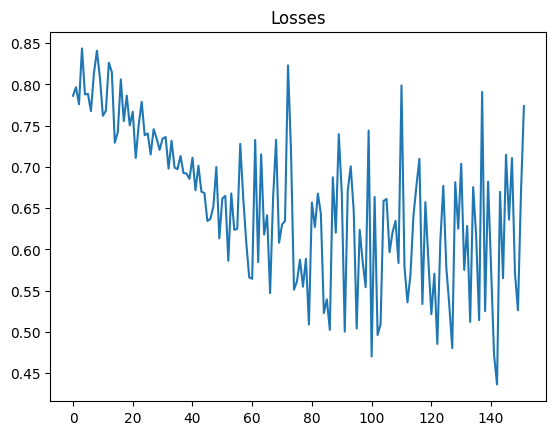

======== Epoch 2 / 5 ========
  Batch    40  of    152.    Elapsed: 0:00:11.
  Batch    80  of    152.    Elapsed: 0:00:22.
  Batch   120  of    152.    Elapsed: 0:00:33.


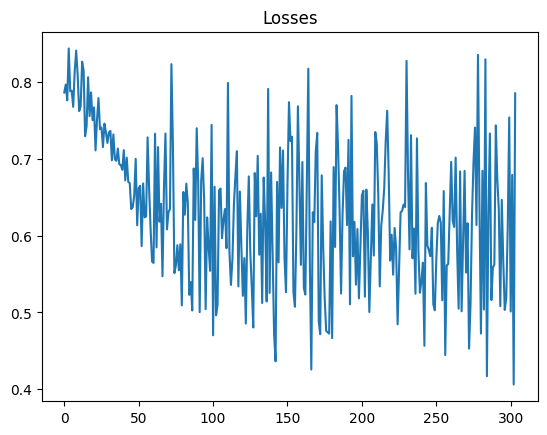

======== Epoch 3 / 5 ========
  Batch    40  of    152.    Elapsed: 0:00:11.
  Batch    80  of    152.    Elapsed: 0:00:22.
  Batch   120  of    152.    Elapsed: 0:00:33.


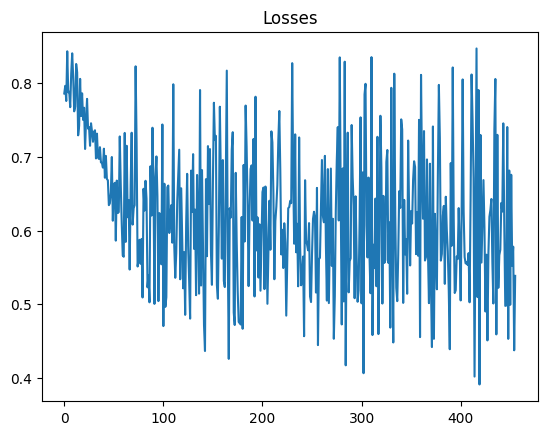

======== Epoch 4 / 5 ========
  Batch    40  of    152.    Elapsed: 0:00:11.
  Batch    80  of    152.    Elapsed: 0:00:22.
  Batch   120  of    152.    Elapsed: 0:00:33.


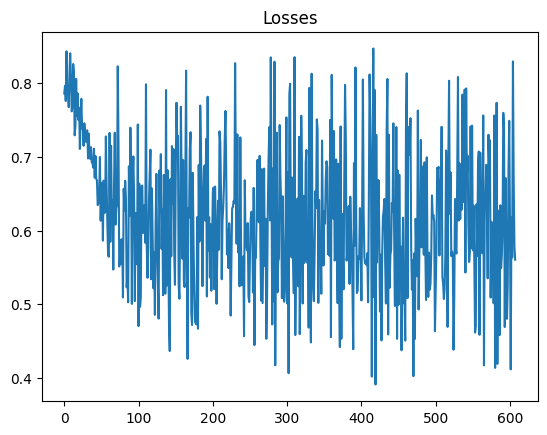

======== Epoch 5 / 5 ========
  Batch    40  of    152.    Elapsed: 0:00:11.
  Batch    80  of    152.    Elapsed: 0:00:22.
  Batch   120  of    152.    Elapsed: 0:00:33.


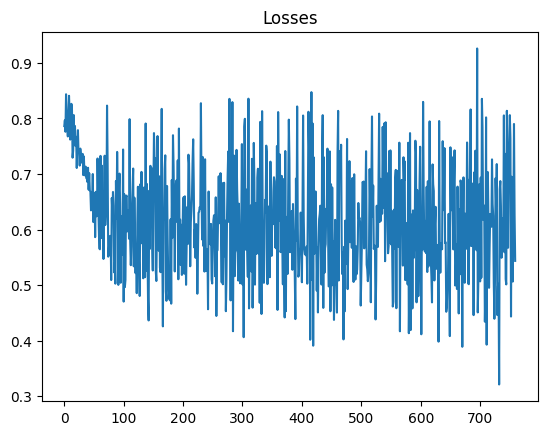

Training complete!
Total training took 0:03:40 (h:mm:ss)


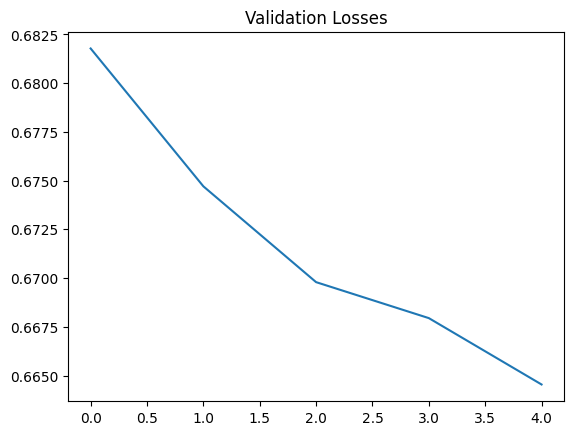

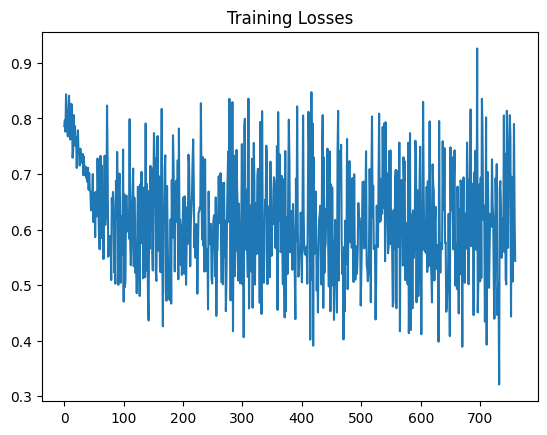

avg_train_loss,█▁▁▁▁
avg_val_loss,█▅▃▂▁
train_batch_loss,▆▆▅▅▂▂▃▄▃▂▃▄▅▄▄▃▂▃▄▃▃▃▄▅▅▂▅▃▅▂▁▆▂▄▃▅█▄▄▃
train_f1,▁████
train_precision,▁████
val_accuracy,▁▃▂▄█
val_f1,▁▁▆▅█
val_precision,█▁▅▂▅
avg_train_loss,0.60875
avg_val_loss,0.66454
train_batch_loss,0.54358


wandb: Agent Starting Run: wflsxxa5 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	learning_rate: 2e-06
wandb: 	loss_function: focal
wandb: 	warmup_percentage: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/raaif/.local/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/raaif/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

batch_size =  16
Learning_rate =  2e-06
epochs =  5
warmup percentage 0.05
======== Epoch 1 / 5 ========
  Batch    40  of    152.    Elapsed: 0:00:11.
  Batch    80  of    152.    Elapsed: 0:00:22.
  Batch   120  of    152.    Elapsed: 0:00:33.


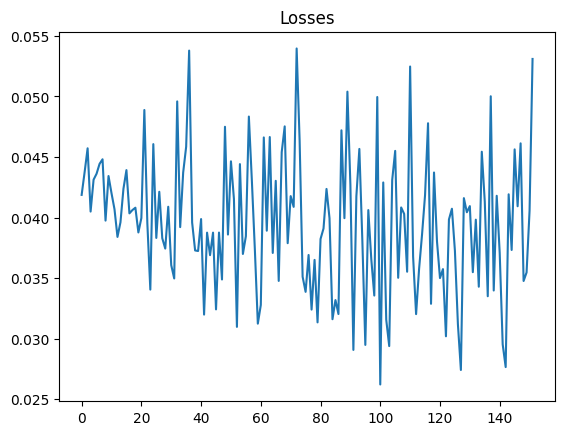

======== Epoch 2 / 5 ========
  Batch    40  of    152.    Elapsed: 0:00:11.
  Batch    80  of    152.    Elapsed: 0:00:22.
  Batch   120  of    152.    Elapsed: 0:00:33.


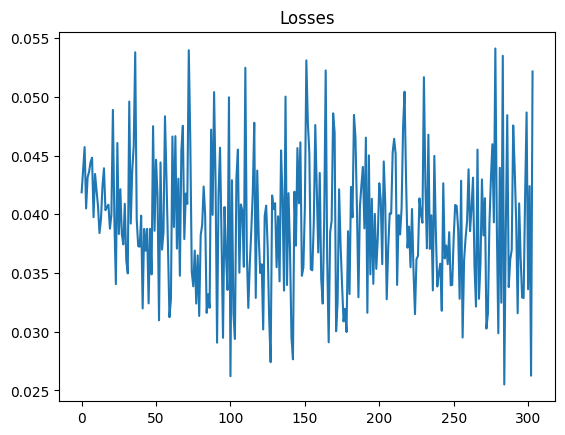

======== Epoch 3 / 5 ========
  Batch    40  of    152.    Elapsed: 0:00:11.
  Batch    80  of    152.    Elapsed: 0:00:22.
  Batch   120  of    152.    Elapsed: 0:00:33.


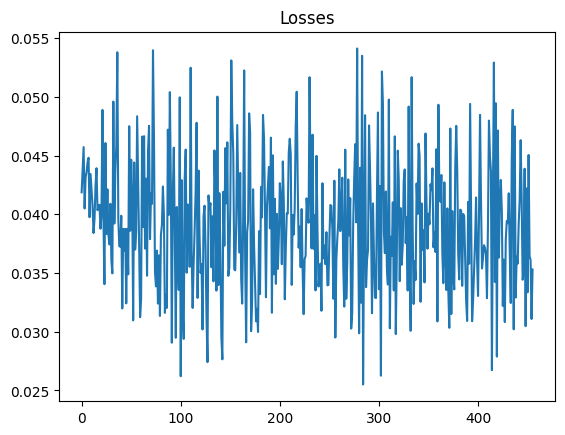

======== Epoch 4 / 5 ========
  Batch    40  of    152.    Elapsed: 0:00:11.
  Batch    80  of    152.    Elapsed: 0:00:22.
  Batch   120  of    152.    Elapsed: 0:00:33.


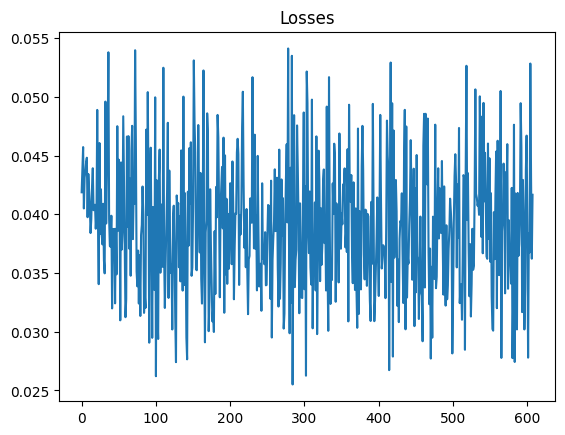

======== Epoch 5 / 5 ========
  Batch    40  of    152.    Elapsed: 0:00:11.
  Batch    80  of    152.    Elapsed: 0:00:22.
  Batch   120  of    152.    Elapsed: 0:00:33.


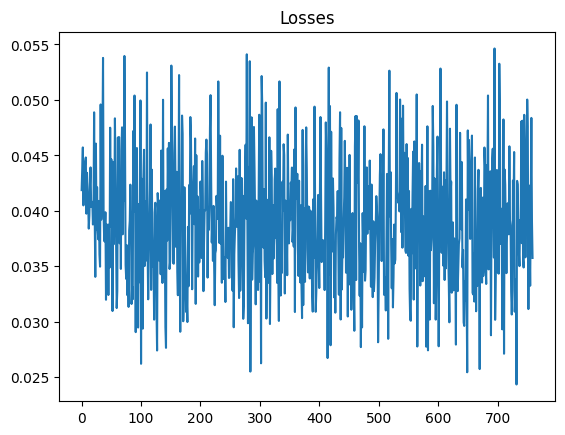

Training complete!
Total training took 0:03:41 (h:mm:ss)


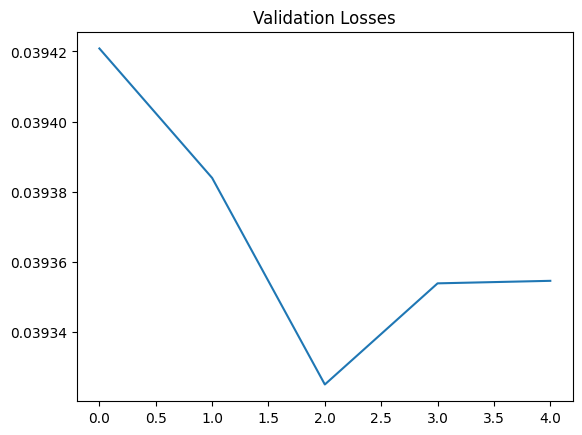

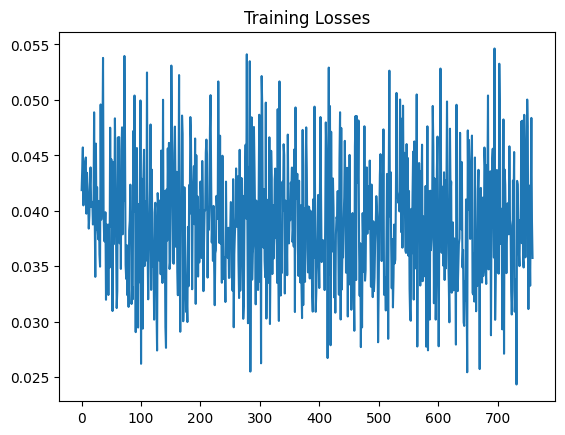

avg_train_loss,█▄▂▃▁
avg_val_loss,█▅▁▃▃
train_batch_loss,▅▃▄▆▂▂▄▅▃▃▄▄▅▅▅▃▂▄▄▃▃▄▅▅▆▂▆▃▆▂▁▆▂▄▄▅█▄▄▃
train_f1,▁████
train_precision,▁████
val_accuracy,▁████
val_f1,▁▁▁▁▁
val_precision,▁▁▁▁▁
avg_train_loss,0.03872
avg_val_loss,0.03935
train_batch_loss,0.03575


wandb: Agent Starting Run: 42yr8gkz with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	learning_rate: 5e-05
wandb: 	loss_function: focal
wandb: 	warmup_percentage: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/raaif/.local/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/raaif/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `m

batch_size =  16
Learning_rate =  5e-05
epochs =  5
warmup percentage 0.05
======== Epoch 1 / 5 ========
  Batch    40  of    152.    Elapsed: 0:00:11.
  Batch    80  of    152.    Elapsed: 0:00:22.
  Batch   120  of    152.    Elapsed: 0:00:33.


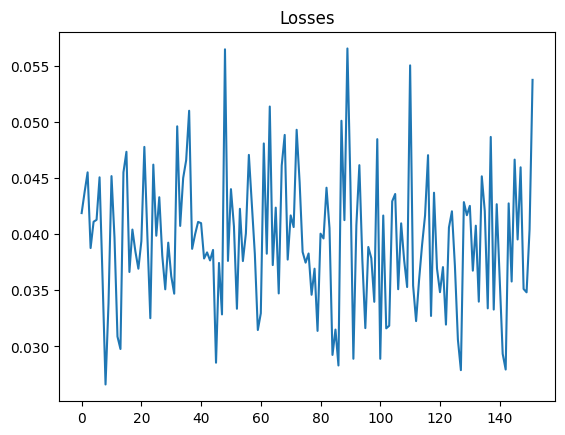

======== Epoch 2 / 5 ========
  Batch    40  of    152.    Elapsed: 0:00:11.
  Batch    80  of    152.    Elapsed: 0:00:22.
  Batch   120  of    152.    Elapsed: 0:00:33.


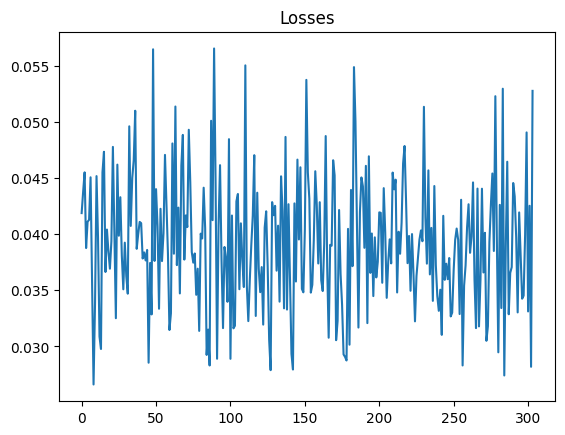

======== Epoch 3 / 5 ========
  Batch    40  of    152.    Elapsed: 0:00:11.
  Batch    80  of    152.    Elapsed: 0:00:22.
  Batch   120  of    152.    Elapsed: 0:00:33.


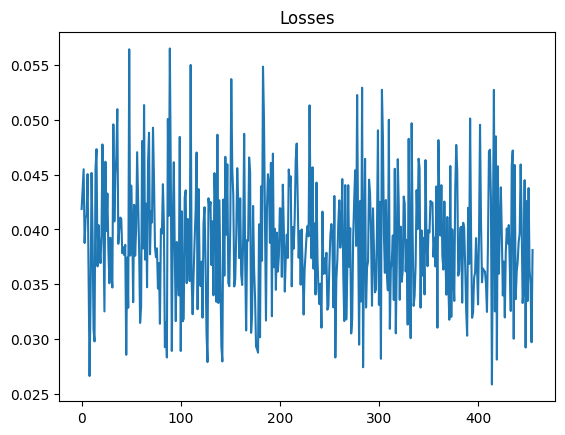

======== Epoch 4 / 5 ========
  Batch    40  of    152.    Elapsed: 0:00:11.
  Batch    80  of    152.    Elapsed: 0:00:22.
  Batch   120  of    152.    Elapsed: 0:00:33.


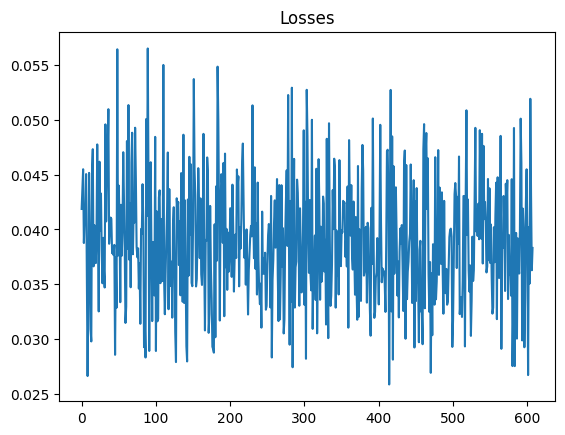

======== Epoch 5 / 5 ========
  Batch    40  of    152.    Elapsed: 0:00:11.
  Batch    80  of    152.    Elapsed: 0:00:22.
  Batch   120  of    152.    Elapsed: 0:00:33.


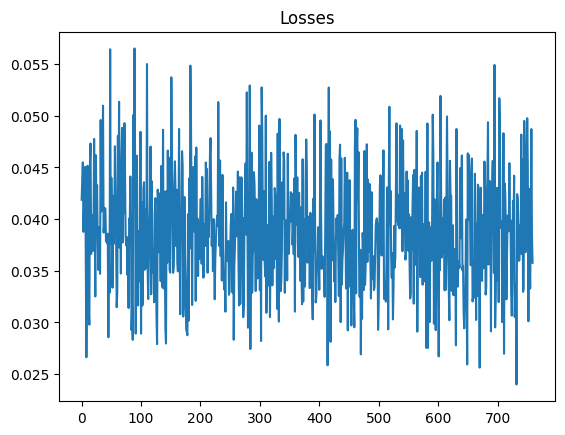

Training complete!
Total training took 0:03:42 (h:mm:ss)


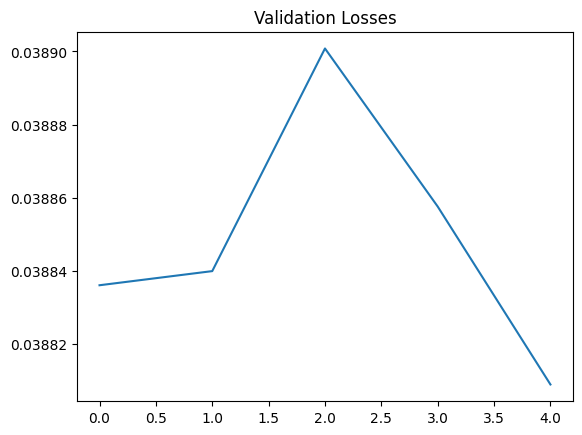

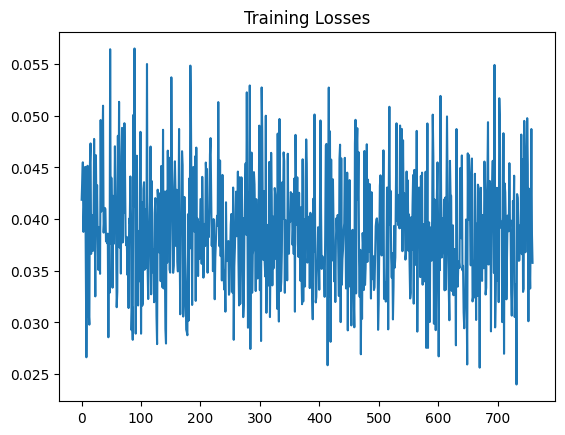

avg_train_loss,█▄▂▂▁
avg_val_loss,▃▃█▅▁
train_batch_loss,▃▂▄▇▂▂▃▅▄▃▄▄▅▅▄▄▂▃▄▄▃▃▄▅▆▂▅▃▅▂▁▆▂▄▃▅█▄▄▃
train_f1,▁████
train_precision,▁████
val_accuracy,▁▁▁▁▁
val_f1,▁▁▁▁▁
val_precision,▁▁▁▁▁
avg_train_loss,0.0385
avg_val_loss,0.03881
train_batch_loss,0.03576


wandb: Ctrl + C detected. Stopping sweep.


In [23]:
wandb.agent(sweep_id,function=train)

In [65]:
import torch
import gc

torch.cuda.empty_cache()

# Call the garbage collector
gc.collect()

# Ensure CUDA is aware of the freed memory
torch.cuda.empty_cache()


In [76]:
labels[:32].unsqueeze(0).view(-1).shape

torch.Size([64])

In [26]:
from torch.utils.data import TensorDataset

# load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.load_state_dict(torch.load('model copy 5.pth'))
model.to(device)

# Put model in evaluation mode
model.eval()

criterion = torch.nn.BCEWithLogitsLoss()

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in X_dev:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 300,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_dev)

# convert to tensors
input_ids = torch.tensor(input_ids)
attention_masks = torch.tensor(attention_masks)
labels = torch.tensor(labels)

# move to GPU
test_input_ids = input_ids.to(device)
test_attention_masks = attention_masks.to(device)
test_labels = labels.to(device)

test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_dataloader = DataLoader(
               test_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = 16 # Evaluate with this batch size.
            )

total_TP = 0
total_FP = 0
total_FN = 0
total_TN = 0

for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(b_input_ids,
                            attention_mask=b_input_mask)

    logits = outputs.logits

    loss = criterion(logits.float(), b_labels.float())

    predictions = torch.argmax(logits, dim=1).cpu()
    b_labels_vals = np.array([b[0].cpu().numpy() for b in b_labels])

    TP = ((predictions == 1) & (b_labels_vals == 1)).sum().item()
    FP = ((predictions == 1) & (b_labels_vals == 0)).sum().item()
    FN = ((predictions == 0) & (b_labels_vals == 1)).sum().item()
    TN = ((predictions == 0) & (b_labels_vals == 0)).sum().item()

    total_TP += TP
    total_FP += FP
    total_FN += FN
    total_TN += TN
    
accuracy = (total_TP + total_TN) / (total_TP + total_FP + total_FN + total_TN)
precision = total_TP / (total_TP + total_FP) if total_TP + total_FP > 0 else 0
recall = total_TP / (total_TP + total_FN) if total_TP + total_FN > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)





Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47873/4358153.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)
/tmp/ipykernel_47873/4358153.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_masks = torch.tensor(attention_masks)
/tmp/ipykernel_47873/4358153.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.cl

Accuracy:  0.08550185873605948
Precision:  0.08550185873605948
Recall:  1.0
F1 Score:  0.15753424657534246
